# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

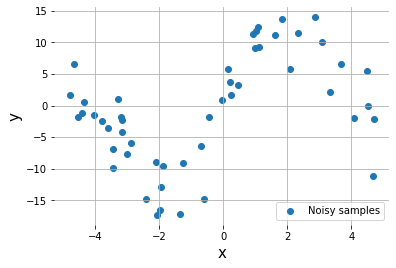

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.box(False)
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')


plot_scatter(X, y)

### Split

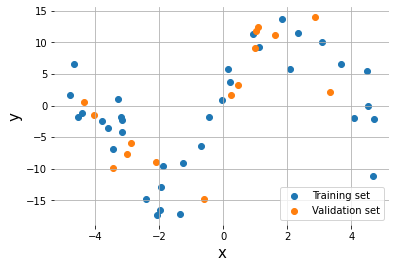

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

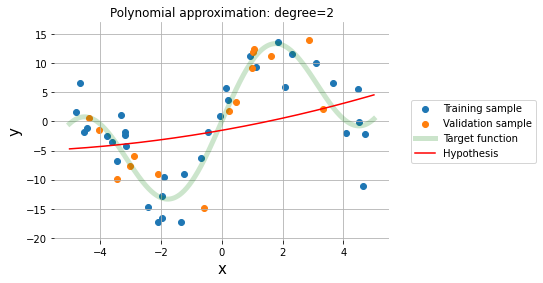

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

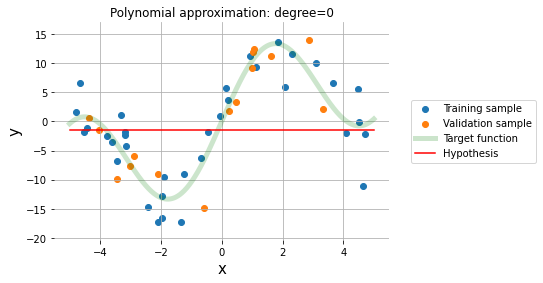

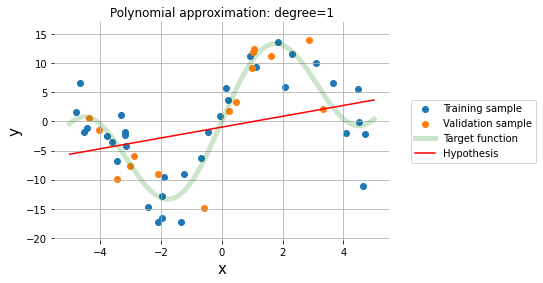

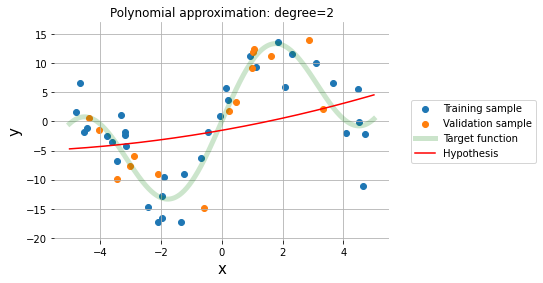

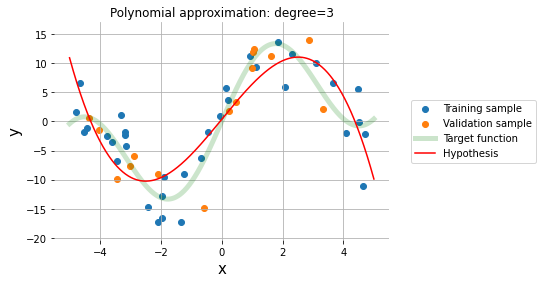

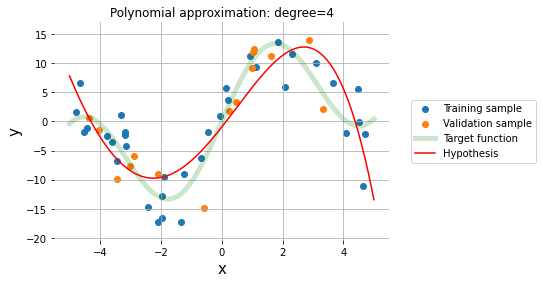

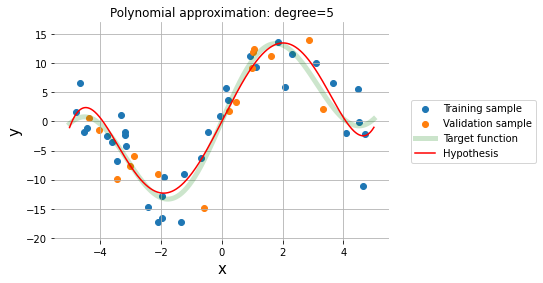

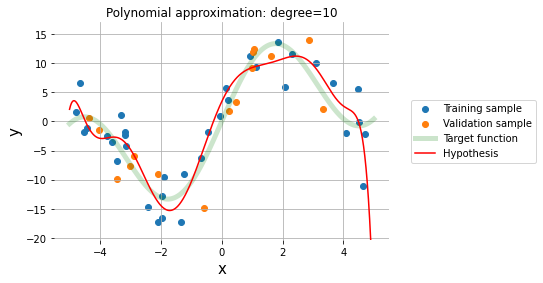

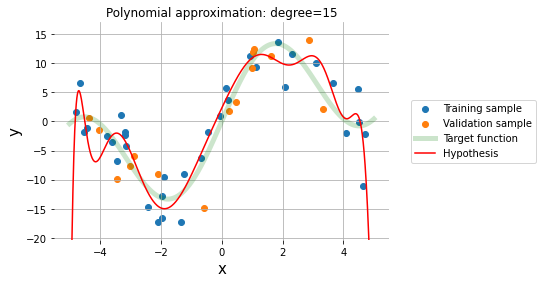

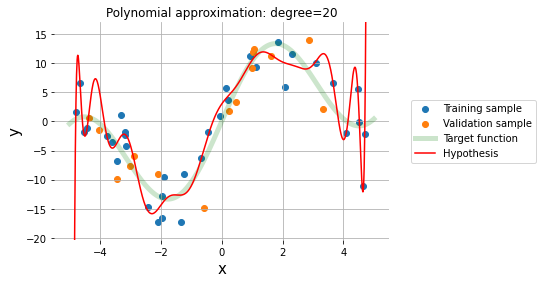

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

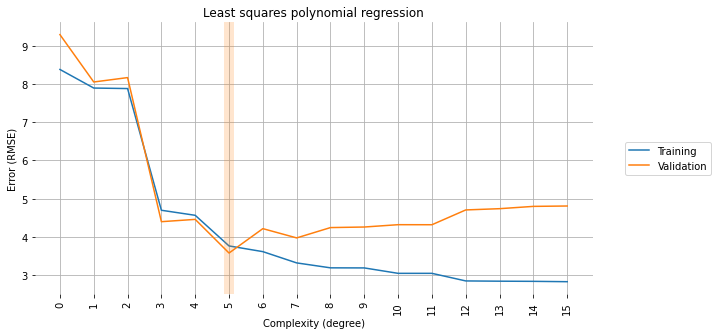

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    
    plt.figure(figsize=(10, 5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.box(False)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right') 
        plt.box(False)
    plt.show()


rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

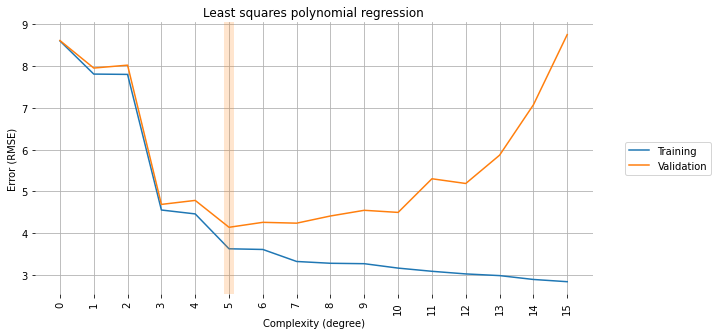

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

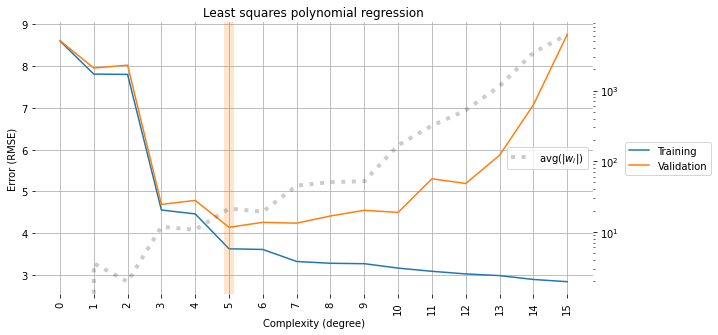

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

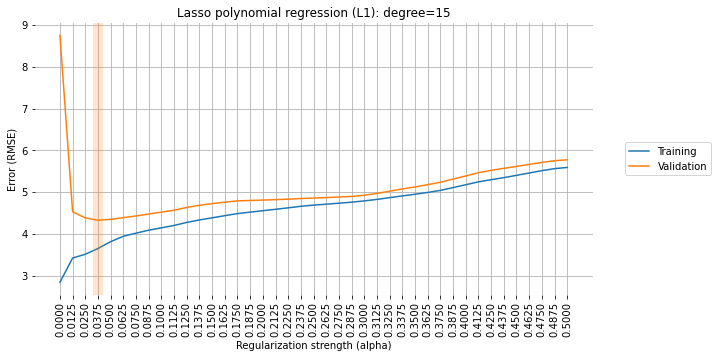

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

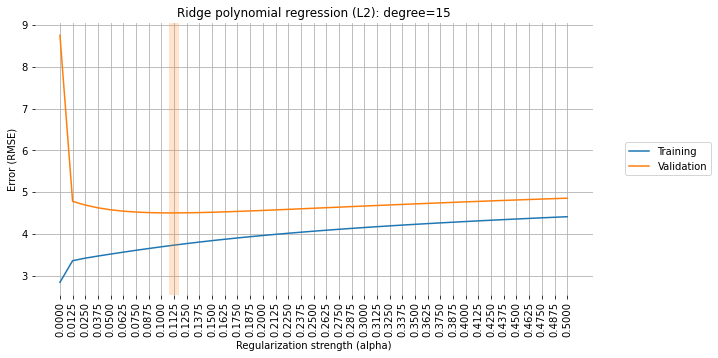

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

# Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

## Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

<hr>

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [21]:
# Let's combine our X and y features into one dataset
df = pd.concat([X_diabetes, y_diabetes], axis=1)
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [22]:
# Let's look at the descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,442.0,-3.634285e-16,0.047619,-0.107226,-0.037299,0.005383,0.038076,0.110727
sex,442.0,1.308343e-16,0.047619,-0.044642,-0.044642,-0.044642,0.050680,0.050680
bmi,442.0,-8.045349e-16,0.047619,-0.090275,-0.034229,-0.007284,0.031248,0.170555
bp,442.0,1.281655e-16,0.047619,-0.112400,-0.036656,-0.005671,0.035644,0.132044
s1,442.0,-8.835316e-17,0.047619,-0.126781,-0.034248,-0.004321,0.028358,0.153914
s2,442.0,1.327024e-16,0.047619,-0.115613,-0.030358,-0.003819,0.029844,0.198788
s3,442.0,-4.574646e-16,0.047619,-0.102307,-0.035117,-0.006584,0.029312,0.181179
s4,442.0,3.777301e-16,0.047619,-0.076395,-0.039493,-0.002592,0.034309,0.185234
s5,442.0,-3.830854e-16,0.047619,-0.126097,-0.033249,-0.001948,0.032433,0.133599
s6,442.0,-3.412882e-16,0.047619,-0.137767,-0.033179,-0.001078,0.027917,0.135612


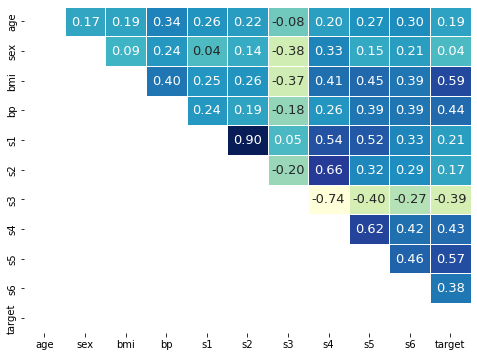

In [23]:
# Let's build correlation matrix and visualize how features correlate with target feature
corr_matrix = df.corr()
mtx = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

plt.figure(figsize=(8, 6))
sns.heatmap(mtx, cmap='YlGnBu', annot=True, fmt='.2f', linewidths=1, annot_kws={'size': 13}, cbar=False);

Let's build scatterplots for each feature in our dataset (except `sex` feature, because it's categorical) and look how they are destributed.

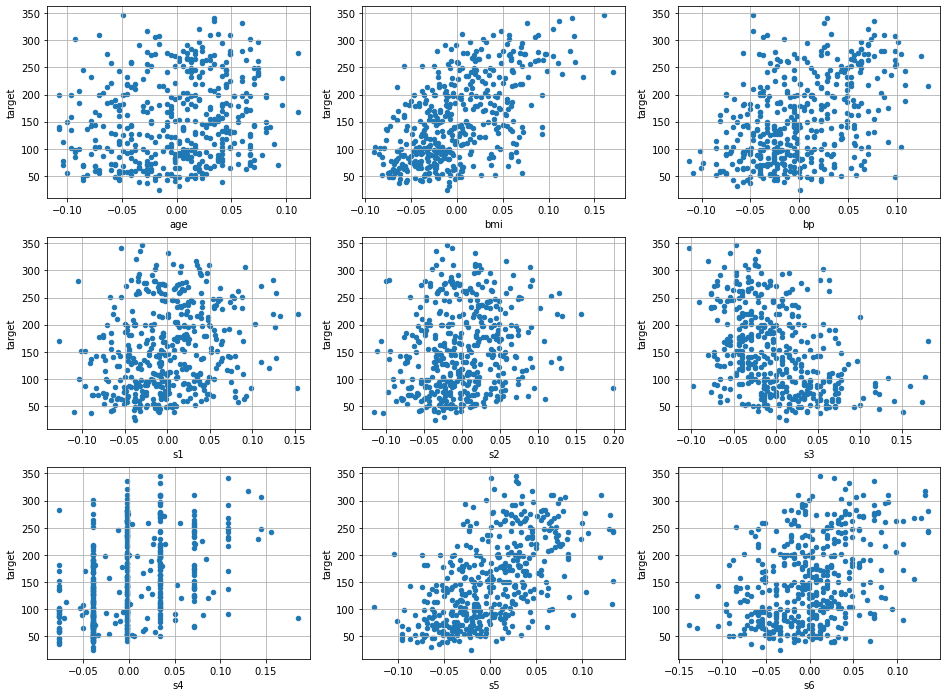

In [24]:
cols = [i for i in df.columns if not i in ['sex', 'target']]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
for idx, feature in enumerate(cols):
    df.plot(feature, 'target', subplots=True, kind='scatter', ax=axes[idx//3, idx%3], grid=True)

We can see that some of the features have rather random destribution, so for modeling let's choose `bmi`, `bp` and `s3` features.

In [25]:
# Defining subset
X_poly = X_diabetes[['bmi', 'bp', 's3']]

#### Let's apply Pypline model for traing and validating using cross validation.

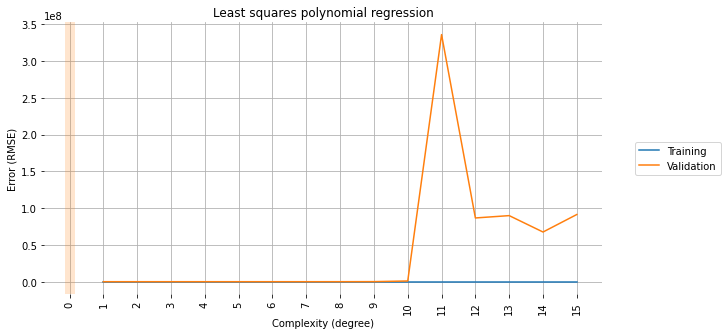

In [26]:
rmse_train, rmse_valid = [], []

for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X_poly, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

The graph shows us that the best choice is the polynomial with 0 degree. The value of RMSE at the degree = 11 is incredibly high - over 300 000 000. Let's use only degrees from 1 to 4.

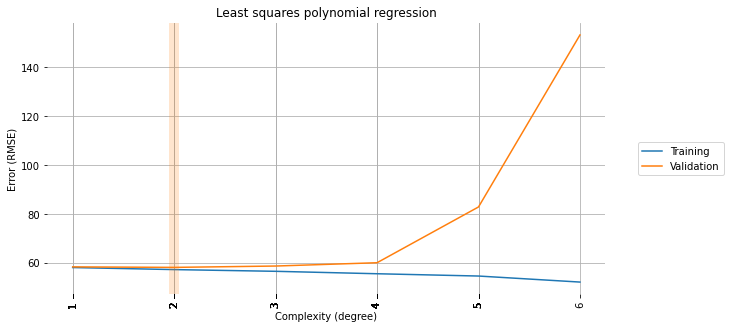

In [27]:
rmse_train, rmse_valid = [], []
DEGREES_2 = np.linspace(1, 6, dtype=int)


for degree in DEGREES_2:
    results = cross_validate(make_model(degree), 
                             X_poly, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))

    
plot_fitting_graph(DEGREES_2, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

**It's clear, that the best choice is the polynomial with 2 degree. Polynomial degrees over 4 will be causing overfitting.**

<hr>

## Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

### L1

Let's split `X_poly` and `y_diabetes` into train and test subsets. We won't use here cross validation because computatinal power of the machine used isn't enough for complex computation.

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X_poly, y_diabetes, test_size=0.3, random_state=SEED)

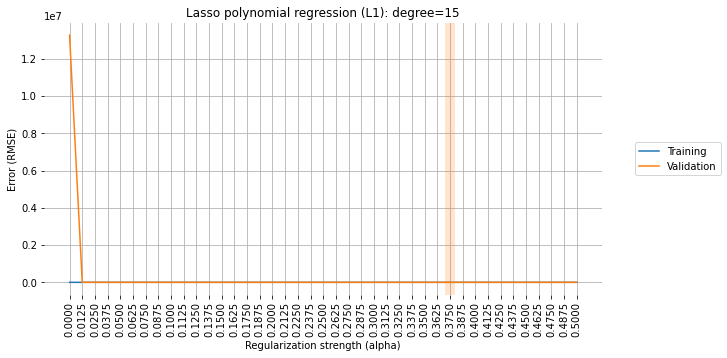

In [29]:
rmse_train, rmse_valid = [], []

for alpha in ALPHAS:    
    lasso_model = make_model(degree=15, penalty='L1', alpha=alpha).fit(X_train, y_train)
    
    rmse_train.append(rmse(lasso_model.predict(X_train), y_train))
    rmse_valid.append(rmse(lasso_model.predict(X_valid), y_valid))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

At the value of ALHA 0.0125 we have an immensely high value of RMSE. Let's drop zero from computation.

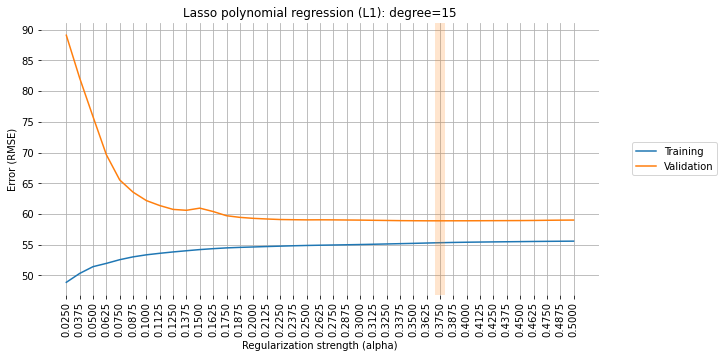

In [30]:
ALPHAS_2 = np.linspace(0.025, 0.5, 1 + 38)

rmse_train, rmse_valid = [], []

for alpha in ALPHAS_2:    
    lasso_model = make_model(degree=15, penalty='L1', alpha=alpha).fit(X_train, y_train)
    
    rmse_train.append(rmse(lasso_model.predict(X_train), y_train))
    rmse_valid.append(rmse(lasso_model.predict(X_valid), y_valid))
    
plot_fitting_graph(ALPHAS_2, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

**We can see that even with the high polynomial degree our model with L1 regularization begins to perform better at the value of alpha 0,1.**

### L2

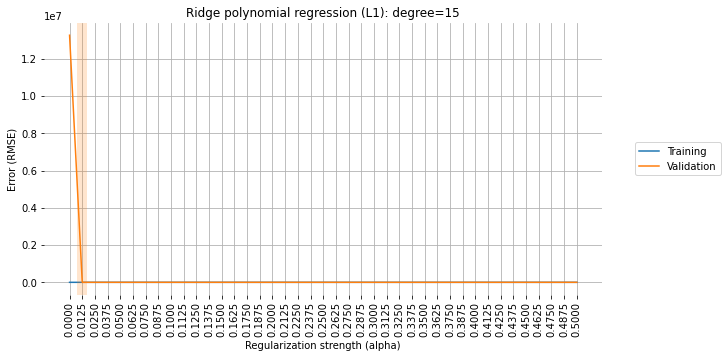

In [31]:
rmse_train, rmse_valid = [], []

for alpha in ALPHAS:    
    ridge_model = make_model(degree=15, penalty='L2', alpha=alpha).fit(X_train, y_train)
    
    rmse_train.append(rmse(ridge_model.predict(X_train), y_train))
    rmse_valid.append(rmse(ridge_model.predict(X_valid), y_valid))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Ridge polynomial regression (L1): degree=15')

Let's drop zero from computation.

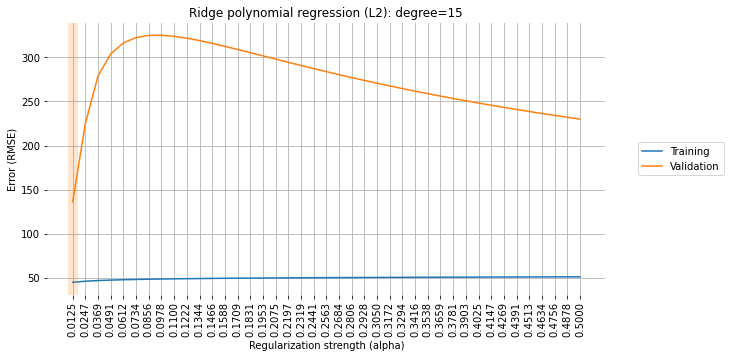

In [32]:
ALPHAS_3 = np.linspace(0.0125, 0.5, 1 + 40)

rmse_train, rmse_valid = [], []

for alpha in ALPHAS_3:    
    ridge_model = make_model(degree=15, penalty='L2', alpha=alpha).fit(X_train, y_train)
    
    rmse_train.append(rmse(ridge_model.predict(X_train), y_train))
    rmse_valid.append(rmse(ridge_model.predict(X_valid), y_valid))
    
plot_fitting_graph(ALPHAS_3, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Ridge polynomial regression (L2): degree=15')

**We can see that even with the high polynomial degree our model with L2 regularization begins to perform better at the value of alpha 0,125.**

### Summary

- Both L1 and L2 regularization help to reduce overfitting. 
- RMSE is lower while using L1 regularization. After the value of alpha 0,375 RMSE doesn't improve significantly.
- Incresing the value of alpha after 0,0125 while using L2 regularization doesn't improve significantly RMSE metric.

## Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

### L1

In [33]:
coefs_lasso = []

for alpha in ALPHAS:    
    lasso_model = make_model(degree=15, penalty='L1', alpha=alpha).fit(X_train, y_train)
    coefs_lasso.append(np.sum(lasso_model['reg'].coef_ == 0))

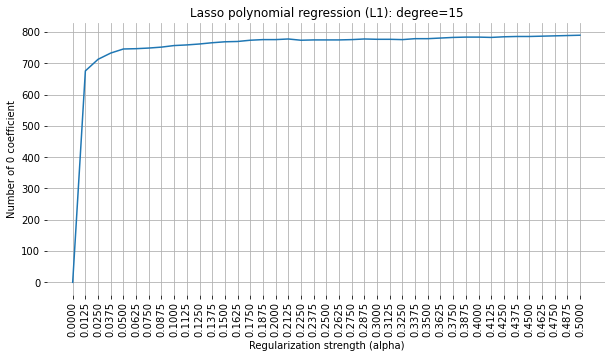

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(ALPHAS, coefs_lasso, label='L1')
plt.box(False)
plt.grid(True)
plt.title('Lasso polynomial regression (L1): degree=15')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Number of 0 coefficient')
plt.xticks(ALPHAS, rotation='vertical');

### L2

In [35]:
coefs_ridge = []

for alpha in ALPHAS:    
    ridge_model = make_model(degree=15, penalty='L2', alpha=alpha).fit(X_train, y_train)
    coefs_ridge.append(np.sum(ridge_model['reg'].coef_ == 0))

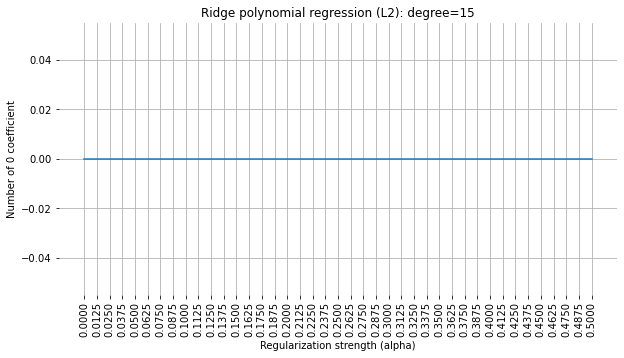

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(ALPHAS, coefs_ridge, label='L1')
plt.box(False)
plt.grid(True)
plt.title('Ridge polynomial regression (L2): degree=15')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Number of 0 coefficient')
plt.xticks(ALPHAS, rotation='vertical');

### Summary

- With the increase of alpha L1 regularization turns weights to zero. At the value of alpha 0 there are 800 weights in the model.
- L2 regularization uses all the features but with the increase of alpha they are more penalized.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [37]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


Let's define the Pipeline with StandardScaler

In [38]:
def make_model_scaled(alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression
    if penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # Ridge regression
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    return Pipeline([
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model_scaled())
display(make_model_scaled(penalty='L1', alpha=0.1))
display(make_model_scaled(penalty='L2', alpha=0.1))

Pipeline(steps=[('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

Let's define the Pipeline without StandardScaler

In [39]:
def make_model_not_scaled(alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # Ridge regression
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    return Pipeline([('reg', regressor)])

display(make_model_not_scaled())
display(make_model_not_scaled(penalty='L1', alpha=0.1))
display(make_model_not_scaled(penalty='L2', alpha=0.1))

Pipeline(steps=[('reg', LinearRegression())])

Pipeline(steps=[('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### L1

Let's use the model without StandardScaler

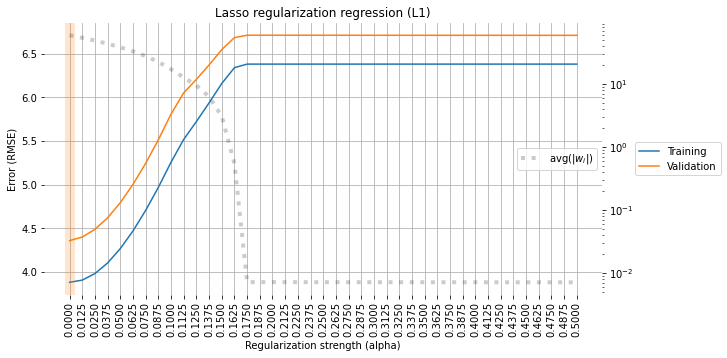

In [40]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:
    results = cross_validate(make_model_not_scaled(penalty='L1', alpha=alpha),
                             X_hw, y_hw, cv=3,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso regularization regression (L1)')

Let's apply the model with StandardScaler

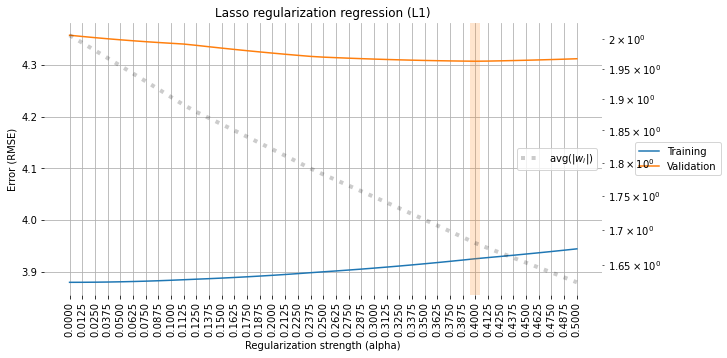

In [41]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:
    results = cross_validate(make_model_scaled(penalty='L1', alpha=alpha),
                             X_hw, y_hw, cv=3,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso regularization regression (L1)')

### L2

Let's use the model without StandardScaler

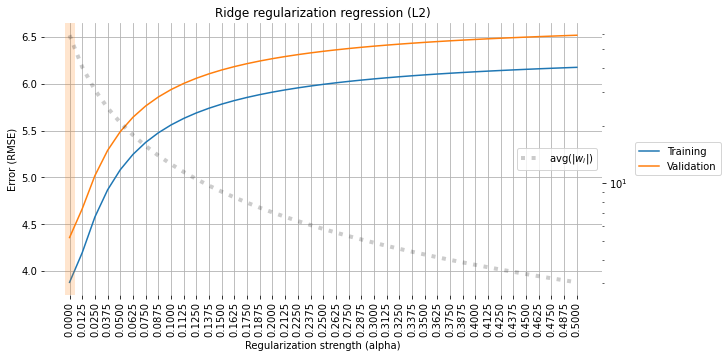

In [42]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:
    results = cross_validate(make_model_not_scaled(penalty='L2', alpha=alpha),
                             X_hw, y_hw, cv=3,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge regularization regression (L2)')

Let's use the model with StandardScaler

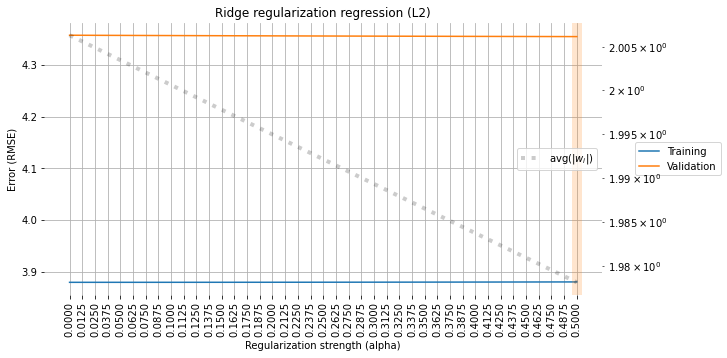

In [43]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:
    results = cross_validate(make_model_scaled(penalty='L2', alpha=alpha),
                             X_hw, y_hw, cv=3,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge regularization regression (L2)')

### Summary

- It is obvious that regularization hasn't significantly improved model performance without data normalization.
- Normalization makes model performance more stable.
- After normalization model's weights also decreased.